# Regression!

Lets try and predict the next value in a linear series of values using regression! We are going to use the MPG dataset

## Imports

In [107]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import tensorflow as tf

pd.set_option("plotting.backend", "plotly")

## Looking at our data

In [108]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = [
    'mpg',
    'cylinders',
    'displacement',
    'horsepower',
    'weight',
    'acceleration',
    'model_year',
    'origin',
]

df = pd.read_csv(
    filepath_or_buffer=url,
    names=column_names,
    comment='\t',
    sep=' ',
    na_values='?',
    skipinitialspace=True
)

Let's look at the distribution now, that should tell us if we need to normalize before we can use the features

In [109]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
cylinders,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
displacement,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
horsepower,392.0,104.469388,38.491160,46.0,75.000,93.5,126.000,230.0
weight,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acceleration,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
model_year,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
origin,398.0,1.572864,0.802055,1.0,1.000,1.0,2.000,3.0


In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [111]:
df.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
dtype: int64

Ok we have very different ranges and scales, so we need to normalise

Next we look for NaN's

Ok, so we can see here that there's a few NaN's, but basically we're ok, we can probably just drop these.

Now we want to make sure that there's some sort of sensible relationship between our output column, and the features. We can see across the board that there is a relationship between the two columns. We can also see that for each of that comparisons that each dataset is a function of each other, or at least they effect one another. This is what makes the dataset suitable for running a regression on it.

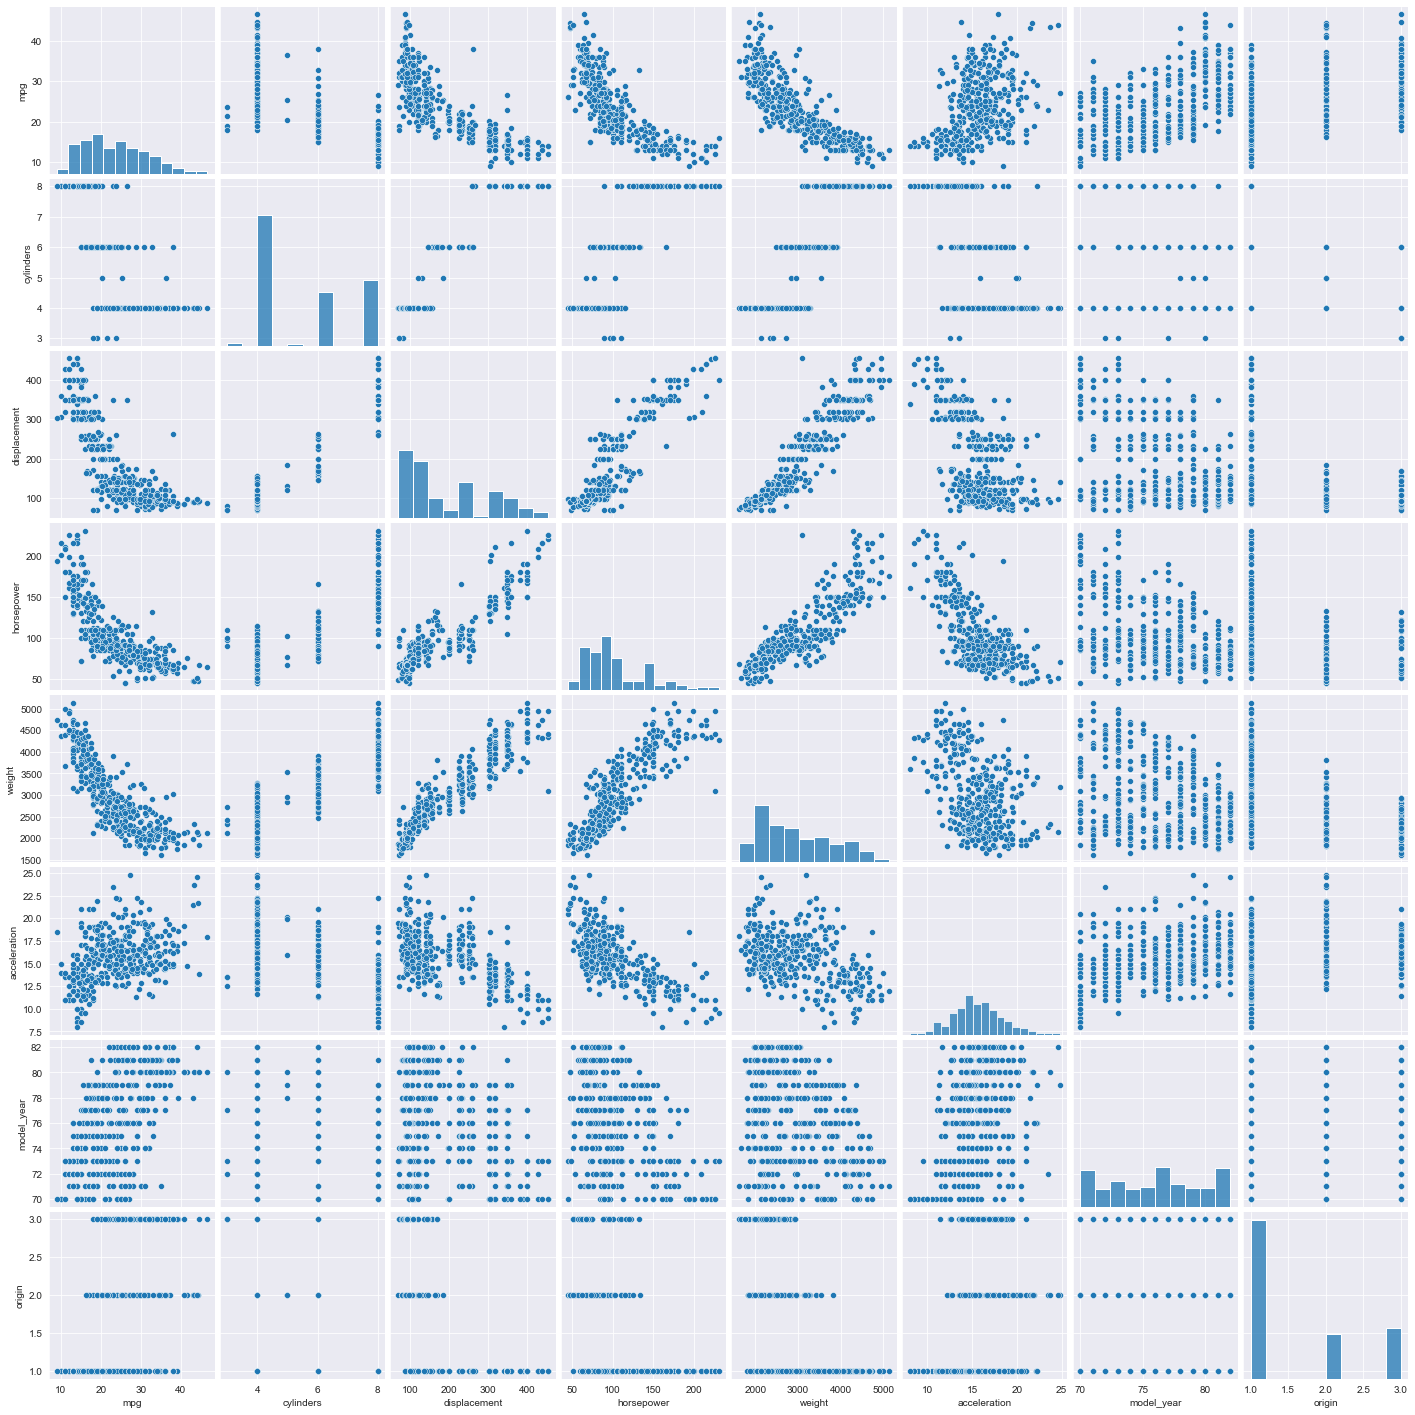

In [112]:
sns.pairplot(df)

## Data Cleaning

There's not many of these, they are kinda a pain for nets, lets just chuck them out, we can also turn the values in the origin field into 3 true false columns that the net can more easily understand

In [113]:
df = (
    df
        .dropna()
        .assign(origin=df.origin.map({1: 'usa', 2: 'europe', 3: 'japan'}))
        .pipe(
        pd.get_dummies,
        columns=['origin'],
        prefix='origin',
        prefix_sep='_'
    )
        .reset_index(drop=True)
)
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin_europe,origin_japan,origin_usa
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1
...,...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
389,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1


## Reserve some test data
We're going to train with 80% of the set

In [114]:
train_dataset = df.sample(frac=0.8)
train_features = train_dataset.drop(columns=["mpg"])
train_label = train_dataset[["mpg"]]
test_dataset = df.drop(train_dataset.index)
test_features = test_dataset.drop(columns=["mpg"])
test_label = test_dataset[["mpg"]]

## Normalize the data
We want to make the ranges the same across the board

In [115]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

## Let's build the model
Ok now our data is looking good! Let's build the net

In [116]:
def build_and_compile_model(normalizer: tf.keras.layers.Normalization) -> tf.keras.callbacks.History:
    model = tf.keras.Sequential(
        [
            normalizer,
            tf.keras.layers.Dense(
                64,
                activation=tf.keras.activations.relu,
                kernel_regularizer=tf.keras.regularizers.l2(0.001)
                ),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(
                64,
                activation=tf.keras.activations.relu,
                kernel_regularizer=tf.keras.regularizers.l2(0.001)
                ),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(1)
        ]
    )

    model.compile(
        loss=tf.keras.losses.MeanAbsoluteError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.mae, tf.keras.metrics.mean_squared_error],

    )
    return model

Lets try training a model

In [117]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
model = build_and_compile_model(normalizer=normalizer)
history = model.fit(
    train_features,
    train_label,
    epochs=1000,
    verbose=0,
    validation_split=0.2,
    callbacks=[callback]
)

## Let's visualise what we have just done

In [118]:
def plot_loss(history: tf.keras.callbacks.History) -> None:
    df = pd.DataFrame(history.history)
    df[["loss", "val_loss"]].plot().show()

In [119]:
def plot_mean_absolute_error(history: tf.keras.callbacks.History) -> None:
    df = pd.DataFrame(history.history)
    df[["mean_absolute_error", "val_mean_absolute_error"]].plot().show()

In [120]:
def plot_mean_squared_error(history: tf.keras.callbacks.History) -> None:
    df = pd.DataFrame(history.history)
    df[["mean_squared_error", "val_mean_squared_error"]].plot().show()

In [121]:
df = pd.DataFrame(history.history)
df

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error
0,23.626610,23.548111,621.156799,21.980532,21.902109,534.928833
1,22.855871,22.777357,585.249695,21.310373,21.231661,506.477112
2,22.232487,22.153526,557.887573,20.542953,20.463593,475.218933
3,21.411074,21.331314,524.043823,19.609934,19.529549,439.233459
4,20.279320,20.198339,482.325867,18.429939,18.348076,396.872650
...,...,...,...,...,...,...
127,4.697186,4.620118,36.933392,2.141505,2.064124,7.803556
128,4.600955,4.523534,37.706150,2.131390,2.053969,7.663638
129,4.634462,4.557014,34.271423,2.137206,2.059838,7.718696
130,4.839350,4.762206,38.785892,2.181073,2.104329,7.687147


In [122]:
plot_loss(history)

In [123]:
plot_mean_squared_error(history)

In [124]:
plot_mean_absolute_error(history)

In [125]:
test_label["mpg"]

1      15.0
6      14.0
8      14.0
14     24.0
15     22.0
       ... 
360    20.2
363    27.0
380    25.0
381    38.0
382    26.0
Name: mpg, Length: 78, dtype: float64

In [126]:
test_predictions = pd.DataFrame(model.predict(test_features)).rename(columns={0: "predicted_mpg"})
comparison = pd.DataFrame(
    {
        "mpg": test_label.reset_index(drop=True)["mpg"],
        "predicted_mpg": test_predictions.reset_index(drop=True)["predicted_mpg"]
    }
    )
comparison

,mpg,predicted_mpg
0,15.0,13.562759
1,14.0,11.804354
2,14.0,11.160984
3,24.0,20.763775
4,22.0,18.260874
...,...,...
73,20.2,24.153381
74,27.0,29.229774
75,25.0,24.648487
76,38.0,25.154360


In [127]:
px.violin(comparison)